In [25]:
%load_ext autoreload
%autoreload 2

import time
from cmath import sqrt
from statistics import mean, median
import numpy
import xarray
import matplotlib.pyplot as plt
from Src.Entities.EvaluationMeasures import evaluate_normal_cumulative_gain
from Src.Entities.RuleParameters import RuleParameters
from Src.Entities.Word2VecRules import word2vec_rules, train_word2vec, word2vec_for_game_object

from Src.Saving.Saving import create_directory_path_if_not_exists, save_data_with_rules, prepare_thresholds_for, \
    save_brute_generated_data
from Src.TestDataGeneration.BruteTestDataGenerator import BruteTestDataGenerator
from Src.TestDataGeneration.TestTagsCreator import create_tags 

brute_generator = BruteTestDataGenerator()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
rule_parameters = RuleParameters()
rule_parameters.k_mn = 2
rule_parameters.k_mx = 3
rule_parameters.s_mn = 0.05
rule_parameters.s_mx = 0.1
rule_parameters.c_mn = 0.8
rule_parameters.c_mx = 1

TAG_CATEGORIES_COUNT = 30
TAG_NAMES_COUNT = 50

GAME_OBJECTS_COUNT = 1000

NOISE_COVER = 3
RULES_COUNT = 10
SEEDS_COUNT = 10
Ks = [1, 3, 5] # Precision at 1, 3, 5

base_directory_path = f"OUTPUT/Word2VecAnalyzing/"
create_directory_path_if_not_exists(base_directory_path)

'OUTPUT/Word2VecAnalyzing/'

In [27]:

def analyze(seed=0, noise_cover=NOISE_COVER, rules_count=RULES_COUNT, game_object_count=GAME_OBJECTS_COUNT):
    # generate data
    
    tags = create_tags(seed, TAG_CATEGORIES_COUNT, TAG_NAMES_COUNT)
    game_objects, expected_rules = brute_generator.generate_without_interference(
        seed=seed,
        tags=tags,
        game_objects_count=game_object_count,
        R_mn = rules_count,
        R_mx = rules_count,
        rule_parameters=rule_parameters,
        noise_cover=noise_cover
    )   
    
    # save generated data
    #save_brute_generated_data(base_directory_path, seed, tags, rule_parameters, game_objects, expected_rules, noise_cover)
    
    # run and save
    model = train_word2vec(game_objects, size=SIZE, min_count=1, alpha=ALPHA,
                                   min_alpha=MIN_ALPHA, epochs=EPOCHS, seed=0)
    
    scores, ranking = evaluate_normal_cumulative_gain(Ks, expected_rules, game_object_count,
                                    lambda game_object, k: word2vec_for_game_object(game_object, k, model))
    
    return scores


In [28]:
def run_experiment_and_save_plot():
    seeds = range(SEEDS_COUNT)
    #game_objects_counts = [100, 1000]
    game_objects_counts = [10, 50, 100, 500, 1000]
    noise_covers = [1, 3, 5]
    #noise_covers = [0, 1, 3, 5]
    #noise_covers = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
    
    data = xarray.DataArray(dims=['game_objects_count', 'noise_cover', 'measure'],
                            data=numpy.ndarray((len(game_objects_counts), len(noise_covers), 6)))
    
    for go_count_index in range(0, len(game_objects_counts)):
        for no_cover_index in range(0, len(noise_covers)):
            go_count = game_objects_counts[go_count_index]        
            no_cover = noise_covers[no_cover_index]        
            evaluations = []
            times = []
            #print(f"Objects: {go_count}, NoiseCover: {no_cover}, Seed: 0-{SEEDS_COUNT}")
            
            for seed in seeds:
                start_timestamp = time.perf_counter()
                
                score = analyze(seed=seed, noise_cover=no_cover, game_object_count=go_count)
                
                evaluations.append(score[Ks[2]])
                times.append(time.perf_counter() - start_timestamp)
            
            data[go_count_index, no_cover_index, 0] = mean(evaluations)
            data[go_count_index, no_cover_index, 1] = median(evaluations)
            data[go_count_index, no_cover_index, 2] = numpy.std(evaluations) / sqrt(len(evaluations))
            data[go_count_index, no_cover_index, 3] = mean(times)
            data[go_count_index, no_cover_index, 4] = median(times)
            data[go_count_index, no_cover_index, 5] = numpy.std(times) / sqrt(len(times))
            
    #print(noise_cover_to_rules_count)      
    
    isel = data.isel(measure=1)
    plt.clf()
    plt.plot(isel)
    plt.xticks(range(len(game_objects_counts)), game_objects_counts)
    alpha_string = f"{ALPHA}".replace(".", "_")
    plot_title = f"{TAG_CATEGORIES_COUNT}_Categories_{TAG_NAMES_COUNT}_Tags_{SIZE}_Size_{alpha_string}_Alpha_{EPOCHS}_Epochs"
    plt.suptitle(plot_title)
    plt.legend([f"{nc} noise cover" for nc in noise_covers])
    plt.ylabel("Normalized Cumulative Gain")
    plt.xlabel("Objects count")
    plt.savefig(f'OUTPUT/Word2Vec/NCG_To_ObjectsCountAndNoiseCover_{plot_title}.png')

c:\users\adams\appdata\local\programs\python\python38\lib\site-packages\xarray\core\indexing.py:1281: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
c:\users\adams\appdata\local\programs\python\python38\lib\site-packages\xarray\core\indexing.py:1281: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
c:\users\adams\appdata\local\programs\python\python38\lib\site-packages\xarray\core\indexing.py:1281: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
c:\users\adams\appdata\local\programs\python\python38\lib\site-packages\xarray\core\indexing.py:1281: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
c:\users\adams\appdata\local\programs\python\python38\lib\site-packages\xarray\core\indexing.py:1281: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
c:\users\a

Progress: 0/48 (0.0%)
Progress: 1/48 (2.083333333333333%)
Progress: 2/48 (4.166666666666666%)
Progress: 3/48 (6.25%)
Progress: 4/48 (8.333333333333332%)
Progress: 5/48 (10.416666666666668%)
Progress: 6/48 (12.5%)
Progress: 7/48 (14.583333333333334%)
Progress: 8/48 (16.666666666666664%)
Progress: 9/48 (18.75%)
Progress: 10/48 (20.833333333333336%)
Progress: 11/48 (22.916666666666664%)
Progress: 12/48 (25.0%)
Progress: 13/48 (27.083333333333332%)
Progress: 14/48 (29.166666666666668%)
Progress: 15/48 (31.25%)
Progress: 16/48 (33.33333333333333%)
Progress: 17/48 (35.41666666666667%)
Progress: 18/48 (37.5%)
Progress: 19/48 (39.58333333333333%)
Progress: 20/48 (41.66666666666667%)
Progress: 21/48 (43.75%)
Progress: 22/48 (45.83333333333333%)
Progress: 23/48 (47.91666666666667%)
Progress: 24/48 (50.0%)
Progress: 25/48 (52.083333333333336%)
Progress: 26/48 (54.166666666666664%)
Progress: 27/48 (56.25%)
Progress: 28/48 (58.333333333333336%)
Progress: 29/48 (60.416666666666664%)
Progress: 30/48 

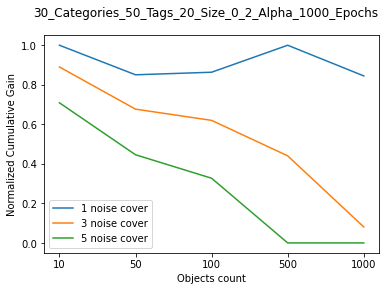

In [29]:
#sizes = [15]
#alphas = [0.1]
#epochs_counts = [1000]

sizes = [5, 10, 15, 20]
alphas = [0.001, 0.01, 0.1, 0.2]
epochs_counts = [10, 100, 1000]

ALL_COUNT =  len(sizes) * len(alphas) * len(epochs_counts)
iteration = 0

for size in sizes:
    for alpha in alphas:
        for epochs in epochs_counts:
            SIZE = size
            ALPHA = alpha
            EPOCHS = epochs
            MIN_ALPHA = ALPHA / EPOCHS
            
            run_experiment_and_save_plot()
            
            print(f"Progress: {iteration}/{ALL_COUNT} ({iteration/ALL_COUNT*100}%)")
            iteration += 1
            
print(f"COMPLETED")

In [30]:
#noise_cover_to_rules_count.plot.line(x='noise_cover',hue='conf',col='supp',col_wrap=5,yscale='symlog')

IndentationError: unexpected indent (<ipython-input-1-c057bda05016>, line 2)